# Text Classification using Word2Vec and LSTM #

## Lili Ayu Wulandhari ##

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import nltk
from nltk.tokenize import word_tokenize

**Load Data**

In [3]:
df=pd.read_csv('train_data.csv')

In [4]:
df.head()

,text,label
0,Here are Thursday's biggest analyst calls: App...,0
1,Buy Las Vegas Sands as travel to Singapore bui...,0
2,"Piper Sandler downgrades DocuSign to sell, cit...",0
3,"Analysts react to Tesla's latest earnings, bre...",0
4,Netflix and its peers are set for a ‘return to...,0


## Exploratory Data Analysis

In [5]:
#shape of data
df.shape

(16990, 2)

In [6]:
#distribution of data label
df['label'].value_counts()

label
2     3545
18    2118
14    1822
9     1557
5      987
16     985
1      837
19     823
7      624
6      524
15     501
17     495
12     487
13     471
4      359
3      321
0      255
8      166
10      69
11      44
Name: count, dtype: int64

In [7]:
#find characteristic some data
for text in df['text'].iloc[0:10]:
    print(text)

Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more  https://t.co/QPN8Gwl7Uh
Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says  https://t.co/fLS2w57iCz
Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition  https://t.co/1EmtywmYpr
Analysts react to Tesla's latest earnings, break down what's next for electric car maker  https://t.co/kwhoE6W06u
Netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside  https://t.co/jPpdl0D9s4
Barclays believes earnings for these underperforming stocks may surprise Wall Street  https://t.co/PHbsyVGAyE
Bernstein upgrades Alibaba, says shares can rally more than 20% from here  https://t.co/m3ApoPRGU0
Analysts react to Netflix's strong quarter, with some pointing to a potential bottom for the stock  https://t.co/cQngJsyefD
Buy Chevron as shares look attractive at these levels, HSBC says  https://t.co/GkDpFvxjEP
Morgan St

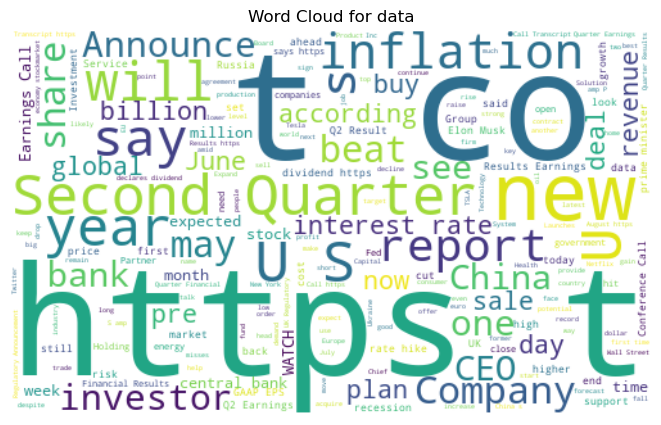

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud to know word overview
words = ' '.join(df['text'])
wordcloud = WordCloud(width=500, height=300, background_color='white').generate(words)

# Plot word cloud for sports
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for data')
plt.axis('off')
plt.show()

## Data Preprocessing

**Text Cleansing**

In [9]:
def cleansing(df):
    df_clean=df.str.lower()
    df_clean=[re.sub(r'\d+',"",i )for i in df_clean]
    df_clean=[re.sub(r'http://\S+|www\S+|https://\S+', ' ', i, flags=re.MULTILINE)for i in df_clean]
    df_clean=[re.sub(r'#\w+', '', i)for i in df_clean]
    df_clean=[re.sub(r'@\w+', '', i)for i in df_clean]
    df_clean=[re.sub(r'[^\w]', ' ', i)for i in df_clean]
    df_clean=[re.sub(r'\s+',' ',i)for i in df_clean]
    
    return df_clean

In [10]:
df['clean_text']=cleansing(df['text'])

In [11]:
df['clean_text'].iloc[0]

'here are thursday s biggest analyst calls apple amazon tesla palantir docusign exxon amp more '

In [12]:
df.head()

,text,label,clean_text
0,Here are Thursday's biggest analyst calls: App...,0,here are thursday s biggest analyst calls appl...
1,Buy Las Vegas Sands as travel to Singapore bui...,0,buy las vegas sands as travel to singapore bui...
2,"Piper Sandler downgrades DocuSign to sell, cit...",0,piper sandler downgrades docusign to sell citi...
3,"Analysts react to Tesla's latest earnings, bre...",0,analysts react to tesla s latest earnings brea...
4,Netflix and its peers are set for a ‘return to...,0,netflix and its peers are set for a return to ...


**Split Data into Train Test**

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size = 0.2, random_state = 42,stratify=df['label'])

In [14]:
x_train.head()

5922     it s ecb rate decision day here s what to expe...
13498    twitter users were quick to spot liz truss see...
4517     jetblue announces webcast of second quarter ea...
16161     calm cal maine foods stock ticks higher on re...
1745     tower semiconductor and cadence expand collabo...
Name: clean_text, dtype: object

In [52]:
print('train:  ',x_train.shape)
print('test:  ',x_test.shape)

train:   (13592,)
test:   (3398,)


**Tokenization, Lemmatization and remove stopword**

In [15]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/liliayu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liliayu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
lemmatizer = WordNetLemmatizer()
list_stopwords = set(stopwords.words('english'))

def prepro_text(text):
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    nonstop_tokens = [word for word in lemmatized if not word in list_stopwords]
    return nonstop_tokens

x_train_fin = [prepro_text(text) for text in x_train]
x_test_fin = [prepro_text(text) for text in x_test]

In [17]:
x_train_fin[0:2]

[['ecb', 'rate', 'decision', 'day', 'expect', 'via', 'amp'],
 ['twitter',
  'user',
  'quick',
  'spot',
  'liz',
  'truss',
  'seemingly',
  'recreating',
  'outfit',
  'margaret',
  'thatcher',
  'appearance',
  'channel',
  'tory',
  'leadership',
  'debate']]

## Text Representation

In [18]:
import gensim
from gensim.models import Word2Vec

# Skipgram
model_skipgram = gensim.models.Word2Vec(x_train_fin, min_count = 3, vector_size = 50, window = 5, sg=1)

In [19]:
#create dictionary
vocabulary_skipgram = model_skipgram.wv.index_to_key
word_vec_dict={}
for word in vocabulary_skipgram:
    word_vec_dict[word]=model_skipgram.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) 

The no of key-value pairs :  6794


In [20]:
# Just display the first 3 word vectors
for i, (word, vec) in enumerate(word_vec_dict.items()):
    if i == 3:
        break
    print(f"{word}: {vec}")  
    

u: [-0.16539423 -0.03160288 -0.0809379  -0.12159896 -0.17888428 -0.5515027
  0.17532013  0.9420628  -0.06139351 -0.3607447   0.00949643 -0.6880983
  0.13530305  0.3209904  -0.49261096 -0.15608487  0.24818067  0.21963671
 -0.8348857   0.13736236  0.1718592   0.3686994   0.4817621  -0.10216037
  0.00434676  0.3087234  -0.2225405   0.51015115 -0.25396332  0.2994056
  0.02865815 -0.21793973 -0.2694116  -0.1871651  -0.08293542  0.49663463
  0.8254985  -0.16475135  0.18423569 -0.49033687 -0.23535788  0.10465042
  0.16852722 -0.02708143  0.08142912  0.29695478 -0.23160467  0.5113652
  0.08805494  0.16317423]
new: [-0.36794534  0.24528025 -0.54962915  0.34472373 -0.18680331 -0.7465976
 -0.16623983  0.36011675 -0.27019528  0.13590622 -0.1558474  -0.6346157
 -0.09304005 -0.13308896 -0.20648314 -0.03762082  0.5136734   0.22836418
 -0.8428966   0.14324115  0.22344403  0.39903587 -0.21368732 -0.3907215
  0.3577247   0.3749676   0.08787996 -0.06308722 -0.1585551   0.22284862
  0.10732885  0.14459069

In [21]:
# Get word vectors
def get_word_vector(model, word):
    try:
        return model.wv.get_vector(word)
    except KeyError:
        # If the word is not in the model, return None
        return None

In [22]:
#represent each token in data into integer unique value
from tensorflow.keras.preprocessing.text import Tokenizer 

tokenize = Tokenizer()
tokenize.fit_on_texts(x_train_fin)
vocab_size = len(tokenize.word_index) + 1 
encode_tok_train = tokenize.texts_to_sequences(x_train_fin)

2025-06-21 22:03:51.378118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
encode_tok_train[0:2]

[[170, 13, 504, 42, 544, 51, 22],
 [157,
  813,
  1879,
  855,
  752,
  655,
  6795,
  9624,
  5431,
  4538,
  3487,
  5432,
  1178,
  733,
  235,
  1421]]

In [24]:
#Padding
from keras.preprocessing.sequence import pad_sequences

#check maximum length of word in sentence
max_seq = max(len(seq) for seq in encode_tok_train)

# now padding to have a maximum length of max_sen
pad_rev_train= pad_sequences(encode_tok_train, maxlen=max_seq, padding='post')
pad_rev_train.shape  

(13592, 48)

In [25]:
pad_rev_train[0:2]

array([[ 170,   13,  504,   42,  544,   51,   22,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 157,  813, 1879,  855,  752,  655, 6795, 9624, 5431, 4538, 3487,
        5432, 1178,  733,  235, 1421,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

In [26]:
vocab_size

17254

In [27]:
# now creating the embedding matrix, embedding matrix is matrix whic mapping each word data into skipgram
embed_dim=50
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))

for word,i in tokenize.word_index.items():
    embed_vector=word_vec_dict.get(word) #mapping the vector to word in our skipgram dictionary
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embed_matrix[i]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.

In [28]:
tokenize.word_index.items()

dict_items([('u', 1), ('new', 2), ('year', 3), ('earnings', 4), ('say', 5), ('stock', 6), ('market', 7), ('inflation', 8), ('q', 9), ('bank', 10), ('price', 11), ('ha', 12), ('rate', 13), ('second', 14), ('quarter', 15), ('result', 16), ('company', 17), ('announces', 18), ('report', 19), ('first', 20), ('call', 21), ('amp', 22), ('china', 23), ('share', 24), ('investor', 25), ('uk', 26), ('energy', 27), ('global', 28), ('week', 29), ('president', 30), ('high', 31), ('financial', 32), ('month', 33), ('may', 34), ('next', 35), ('time', 36), ('billion', 37), ('revenue', 38), ('oil', 39), ('june', 40), ('beat', 41), ('day', 42), ('growth', 43), ('sale', 44), ('fed', 45), ('group', 46), ('ceo', 47), ('dividend', 48), ('gas', 49), ('one', 50), ('via', 51), ('inc', 52), ('b', 53), ('could', 54), ('point', 55), ('interest', 56), ('top', 57), ('fund', 58), ('pre', 59), ('buy', 60), ('back', 61), ('supply', 62), ('wa', 63), ('russia', 64), ('deal', 65), ('see', 66), ('million', 67), ('said', 68)

In [29]:
embed_matrix.shape

(17254, 50)

In [30]:
embed_matrix[0:3]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.16539423, -0.03160288, -0.0809379 , -0.12159896, -0.17888428,
        -0.5515027 ,  0.17532013,  0.9420628 , -0.06139351, -0.36074471,
         0.00949643, -0.68809831,  0.13530305,  0.32099041, -0.49261096,
        -0.15608487,  0.24818067,  0.21963671, -0.

## Text Classification Model: LSTM

**Training**

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.initializers import Constant
from tensorflow.keras.layers import Dense, Embedding, Activation, Flatten
from keras.optimizers import Adam

In [32]:
model = keras.Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_seq,embeddings_initializer=Constant(embed_matrix)))
model.add(layers.LSTM(64, input_shape=(None, 28)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(20))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 50)            862700    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 893696 (3.41 MB)
Trainable params: 893568 (3.41 MB)
Non-trainable params: 128 (512.00 Byte)
_________________________________________________________________
None


In [43]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"])


In [44]:
model.fit(pad_rev_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
850/850 [==============================] - 18s 19ms/step - loss: 1.2979 - accuracy: 0.6115
Epoch 2/10
850/850 [==============================] - 17s 20ms/step - loss: 0.9885 - accuracy: 0.7176
Epoch 3/10
850/850 [==============================] - 17s 20ms/step - loss: 0.8011 - accuracy: 0.7725
Epoch 4/10
850/850 [==============================] - 17s 20ms/step - loss: 0.6102 - accuracy: 0.8293
Epoch 5/10
850/850 [==============================] - 17s 20ms/step - loss: 0.4841 - accuracy: 0.8653
Epoch 6/10
850/850 [==============================] - 17s 20ms/step - loss: 0.3919 - accuracy: 0.8934
Epoch 7/10
850/850 [==============================] - 17s 20ms/step - loss: 0.2913 - accuracy: 0.9250
Epoch 8/10
850/850 [==============================] - 17s 20ms/step - loss: 0.2565 - accuracy: 0.9335
Epoch 9/10
850/850 [==============================] - 17s 20ms/step - loss: 0.2249 - accuracy: 0.9427
Epoch 10/10
850/850 [==============================] - 17s 20ms/step - loss: 0.203

**Testing**

In [45]:
#represent each token in data into integer unique value
encode_tok_test = tokenize.texts_to_sequences(x_test_fin)

In [46]:
#make passing for testing data
pad_rev_test= pad_sequences(encode_tok_test, maxlen=max_seq, padding='post')
pad_rev_test.shape 

(3398, 48)

In [47]:
test_predict=model.predict(pad_rev_test)
class_test=np.argmax(test_predict,axis=1)

107/107 [==============================] - 1s 6ms/step


In [48]:
test_predict

array([[ 1.1326869 ,  1.4462746 , -0.7582833 , ..., -4.4462657 ,
         0.52165675, -1.3527759 ],
       [-0.30190557,  3.5333934 , -0.05992794, ..., -1.0254393 ,
         2.3295908 , -2.4596393 ],
       [ 0.291359  , -3.4979203 ,  1.2402724 , ...,  1.9021907 ,
         5.49333   ,  5.193677  ],
       ...,
       [ 2.3631713 , -2.214204  ,  1.8394556 , ..., -0.98705137,
         9.713977  ,  3.237489  ],
       [-1.072323  , -0.9292925 ,  9.036344  , ...,  1.3225265 ,
         1.9579773 ,  0.19210318],
       [ 1.3250484 , -2.3178048 ,  1.9529111 , ..., -4.024759  ,
         0.97392726,  4.1050906 ]], dtype=float32)

## Evaluation

In [49]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix

In [50]:
print('\nClassification Report\n')
print(classification_report(y_test, class_test, target_names=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']))


Classification Report

              precision    recall  f1-score   support

           0       0.27      0.29      0.28        51
           1       0.83      0.77      0.80       167
           2       0.78      0.70      0.74       709
           3       0.64      0.64      0.64        64
           4       0.93      0.93      0.93        72
           5       0.89      0.95      0.92       198
           6       0.87      0.80      0.83       105
           7       0.83      0.82      0.82       125
           8       0.45      0.70      0.55        33
           9       0.59      0.63      0.61       311
          10       0.47      0.64      0.55        14
          11       0.06      0.11      0.08         9
          12       0.63      0.84      0.72        97
          13       0.42      0.60      0.49        94
          14       0.75      0.81      0.78       364
          15       0.89      0.70      0.78       100
          16       0.88      0.86      0.87       197
   